In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import librosa
import random
import torch 
from torch.utils.data import Dataset , DataLoader
from torch import nn
import torchaudio
import torchvision
from torchvision import transforms
from tqdm import tqdm
from timeit import default_timer as timer
import torchaudio.functional as F
import torchaudio.transforms as T
import requests
device = "cuda"  if torch.cuda.is_available() else "cpu"

In [4]:
train_df = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
bird_taxonomy = pd.read_csv("/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv")
base_dir = Path("/kaggle/input/birdclef-2023/train_audio")

In [37]:
class BirdClef(Dataset):
    def __init__(self, base_dir , df , sampling_rate = 32000 , num_mels = 128 , 
                 min_freq = 128 , max_freq = 16000 , n_fft = 3200 
                 , hop_length = 80 , num_samples  = None , device = device , transforms = None)-> None:
        self.base_dir = base_dir
        self.df = df
        self.sr = sampling_rate
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_mels = num_mels
        if num_samples != None:
            self.num_samples = num_samples
        else:
            self.num_samples = 5*self.sr
        self.device = device
        self.transforms = transforms
        
        
    def __len__(self):
        return len(self.df)
    
    def __getclasses__(self):
        classes = sorted(entry.name for entry in os.scandir(self.base_dir) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_index = {class_name: i for i , class_name in enumerate(classes)}
        self.classes = class_to_index
        return class_to_index
    
    def load_mel_spec(self , index):
        audio_path = self.base_dir / self.df.filename[index]
        audio_tensor , sr = torchaudio.load(audio_path)
        resampler = T.Resample(sr, self.sr).to(self.device)
        if sr!= self.sr:
            audio_tensor = resampler(audio_tensor)
        if audio_tensor.shape[1] > self.num_samples:
            audio_tensor = audio_tensor[:,:self.num_samples]
        audio_length = audio_tensor.shape[1]
        if audio_tensor.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - audio_length
            last_dim_padding = (0, num_missing_samples)
            audio_tensor = torch.nn.functional.pad(audio_tensor , last_dim_padding)
        
        transform = nn.Sequential(T.MelSpectrogram(sample_rate = self.sr,
                                                  n_fft = self.n_fft , hop_length = self.hop_length,
                                                  n_mels = self.num_mels , f_min = self.min_freq,
                                                  f_max = self.max_freq) ,
                                  T.AmplitudeToDB()).to(device)
        audio_tensor_mel_spec = transform(audio_tensor.to(device))
        return audio_tensor_mel_spec
    
    
    def __getitem__(self, index):
        mel_spec = self.load_mel_spec(index)
        class_to_index = self.__getclasses__()
        label = class_to_index[train_df.primary_label[index]]
        mel_spec_img = torch.stack([mel_spec.squeeze() , mel_spec.squeeze() , mel_spec.squeeze()] )
        if self.transforms!= None:
            return self.transforms(mel_spec_img) , torch.tensor(label)
        return mel_spec_img , torch.tensor(label)

### Default parameters are from reference 

* Added ones match AST input size -> are below down in the notebook



In [ ]:
dataset = BirdClef(base_dir , train_df, hop_length = 157)
dataset[10][0].permute(1,2,0).cpu().numpy()
print(dataset[12345][1])
plt.imshow((dataset[1354][0][0].cpu().numpy())/255)

In [ ]:
dataset[23][0].shape

In [ ]:
audio , sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/afghor1/XC169690.ogg")
audio = librosa.feature.melspectrogram(y = audio , sr = 32000 , n_fft = 2048,hop_length = 80  )
audio  = librosa.power_to_db(audio).astype(np.float32)
librosa.display.specshow(audio)

In [4]:
import timm
class BirdClefModel(nn.Module):
    def __init__(self , output_size = 264):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True)
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.classifier = nn.Sequential(nn.Dropout(p = 0.2 , inplace = True)
            ,nn.Linear(in_features = 1280 , out_features = output_size , bias = True))
        
        
    def forward(self , x):
        return self.model(x)

In [ ]:
import timm
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=264).to(device)
model(torch.rand(1,3,224,224))
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size of the model
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])
torch.manual_seed(12)
data = BirdClef(base_dir , train_df, transforms = transform)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data , test_data = torch.utils.data.random_split(dataset = data ,lengths = [ train_size , test_size])
model(data[0][0].unsqueeze(dim = 0))

In [ ]:
request = requests.get("https://github.com/u-r-a-bot/Bird_clef_audio_proc/raw/main/prediction/model_effnet_b0_model.pth")
with open("model_effnet_b0_model.pth" , "wb") as f:
    f.write(request.content)
model = torch.load("model_effnet_b0_model.pth" , map_location=torch.device('cpu')).to(device)

In [ ]:

from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
flag = False
if dataset[0][0].shape[0] == 1:
    flag = True
    model.model.conv_stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32)).to(device)
print("Model Was changed") if flag else print("Model was not changed")

In [ ]:
device

In [39]:
torch.manual_seed(12)
data = BirdClef(base_dir , train_df)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data , test_data = torch.utils.data.random_split(dataset = data ,lengths = [ train_size , test_size])
len(train_data) , len(test_data) , len(data)

(13552, 3389, 16941)

In [ ]:
# import multiprocessing
# import torch
# from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split

# # Define a function to extract labels from a batch
# def process_batch(batch):
#     return [sample[1] for sample in batch]

# # Assuming you have defined your BirdClef dataset class

# # Set random seed for reproducibility
# torch.manual_seed(12)

# # Create your dataset instance
# data = BirdClef(base_dir, train_df)

# # Initialize an empty list to store labels
# labels = []

# # Initialize the number of processes to use
# num_processes = multiprocessing.cpu_count()

# # Create a multiprocessing pool
# pool = multiprocessing.Pool(processes=num_processes)

# # Create a DataLoader for the dataset
# batch_size = 128
# data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

# # Use parallel processing to extract labels from batches
# for batch_labels in pool.imap_unordered(process_batch, data_loader):
#     labels.extend(batch_labels)

# # Close the multiprocessing pool
# pool.close()
# pool.join()

# # Perform stratified split
# train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, stratify=labels)

# # Create data loaders for training and testing
# train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
# test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
# train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler)
# test_loader = DataLoader(data, batch_size=batch_size, sampler=test_sampler)

# # Example usage
# print("Training set size:", len(train_indices))
# print("Testing set size:", len(test_indices))


In [5]:
len(train_data) , len(test_data)

(13552, 3389)

In [ ]:
all_paths = base_dir.glob("*/")
all_paths = sorted([x for x in all_paths])
weight = []
for path in all_paths:
    weight.append(len(list(path.glob("*/"))))
weight = torch.Tensor(weight)
print(f"Before Probabilities:- {weight}")
sum_weight = torch.sum(weight)
probabilities = weight / sum_weight
print(f"After Probabilities:- {probabilities}")
weights_needed = 1 - probabilities
print(f"Final weights:- {weights_needed* 10}")
weights_needed = weights_needed.to(device)

In [ ]:
import numpy as np

# Assuming your dataset is stored in a variable named 'weights'
weights = weight.numpy()

# Calculate statistical measures
median = np.median(weights)
percentile_25 = np.percentile(weights, 25)
percentile_75 = np.percentile(weights, 75)
iqr = percentile_75 - percentile_25

# Generate initial weights based on statistical measures
initial_weights = np.zeros_like(weights)

# Example: Assign weights based on proximity to the median and whether data falls within IQR
initial_weights = np.where((weights >= percentile_25) & (weights <= percentile_75), 1.0, 0.0)
initial_weights[weights < median] += 0.5
initial_weights[weights > median] -= 0.5

# Adjust weights to ensure distinctness
unique_initial_weights = np.unique(initial_weights)
increment = 0.001  # Increment value to ensure distinctness
for i in range(len(initial_weights)):
    initial_weights[i] += increment * i

print("Weights:", (initial_weights + 1)*10)

In [40]:
train_dataloader = DataLoader(dataset = train_data , batch_size = 32 , shuffle = True , num_workers = 0)
test_dataloader = DataLoader(dataset = test_data , batch_size = 32 , shuffle = False , num_workers =0)
dataloader1 = DataLoader(dataset = test_data , batch_size = 32 , shuffle = False , num_workers =0)
dataloader3 = DataLoader(dataset = train_data , batch_size = 32 , shuffle = True , num_workers = 0)

In [ ]:
for params in model.parameters():
    params.requires_grad = True

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader) , desc="Batch"  , leave = False,total = len(dataloader)):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=4)

In [ ]:
model_0_results

In [ ]:
model_path = Path("model_path")
model_path.mkdir(exist_ok = True , parents = True)
torch.save(obj = model.to("cpu") , f = model_path / "model_effnet_b0_model.pth")
torch.save(obj = (model.to("cpu")).state_dict() , f = model_path / "model_effnet_b0_state_dict.pth")

# AST trial(using transformers)


* Trying to use AST with random initialized weights on input_size = 128,2001
* Trying Feature Extractor







In [ ]:
import transformers
class AST_Model(nn.Module):
    def __init__(self, hidden_size = 768 , num_hidden_layers = 6 , max_length = 2001
                                ,num_mel_bins = 128):
        super().__init__()
        config = transformers.ASTConfig(hidden_size = 768 , num_hidden_layers = 6 , max_length = 2001
                                ,num_mel_bins = 128)
        model = transformers.ASTForAudioClassification(config)
        in_features = model.classifier.dense.in_features
        model.classifier.dense = nn.Linear(in_features ,264)
        self.model = model
        
    def forward(self , x):
        return self.model(x)
model = AST_Model()

In [ ]:
model = transformers.ASTFeatureExtractor(feature_size = 264,
                 sampling_rate = 16000,
                 num_mel_bins = 128,max_length = 1024)
model(librosa.load("/kaggle/input/birdclef-2023/test_soundscapes/soundscape_29201.ogg"))

## Feature Extractor Class
* It is a data pipeline for feeding input to AST model 

In [ ]:

# import transformers

# class ASTFeatureExtractor(nn.Module):
#     def __init__(self, feature_size = 264,
#                  sampling_rate = 16000,
#                  num_mel_bins = 128,max_length = 1024):
#         super().__init__()
#         self.model = transformers.ASTFeatureExtractor(feature_size=feature_size,
#                                                          sampling_rate = 32000,
#                                                         num_mel_bins = num_mel_bins,
#                                                         max_length = max_length)
#     def forward(self , x):
#         return self.model(x)
# model = ASTFeatureExtractor(sampling_rate = 32000)


* This  method is useful for converting data and is not used for modelling purposes

In [ ]:
from transformers import ASTFeatureExtractor
import torch
import librosa

# Initialize the feature extractor
feature_extractor = ASTFeatureExtractor(
    feature_size=1,
    sampling_rate=32000,
    num_mel_bins=128,
    max_length=1024,
    padding_value=0.0,
    do_normalize=True,
    mean=-4.2677393,
    std=4.5689974,
    return_attention_mask=False
)

audio, sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/abhori1/XC120250.ogg", sr=None)


audio_tensor = torch.from_numpy(audio)

features = feature_extractor(raw_speech=audio_tensor, sampling_rate=sr , return_tensors = 'pt')

print(features['input_values'].shape)


In [ ]:
audio,sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/abhori1/XC120250.ogg")
model(raw_speech = torch.from_numpy(audio))

### Trying from pretrained Method of AST

* Pretrained method of AST

In [ ]:
from transformers import ASTModel, ASTConfig
import transformers
import torch
from torch import nn
config = transformers.ASTConfig(hidden_size = 768 ,max_length = 2001
                                ,num_mel_bins = 128)


# model = ASTModel.from_pretrained("JamesStratford/ast-finetuned-voice-of-birds",config = config)
class Pretrained_AST(nn.Module):
    def __init__(self , out_features = 264):
        super().__init__()
        config = transformers.ASTConfig(hidden_size = 768 
                            ,num_mel_bins = 128)
        self.model = ASTModel.from_pretrained("JamesStratford/ast-finetuned-voice-of-birds",config = config)
        self.head = nn.Sequential( nn.LayerNorm(768 , eps = 1e-12,elementwise_affine=True),
                                   nn.Linear(in_features = 768 , out_features = out_features)
                                 )
        
    def forward(self ,x):
        outputs = self.model(x)
        hidden_states = outputs.last_hidden_state
        normalized_states = nn.LayerNorm(768, eps=1e-12, elementwise_affine=True)(hidden_states)
        return self.head(normalized_states)
        
        


# Working Model Definition
* It uses pretrained model for hugging face 
* Dataset is adapted to match model input requirements


## Average pooling not done see original AST Code for reference

In [ ]:
from transformers import ASTModel, ASTConfig, AutoFeatureExtractor
import transformers
import torch
from torch import nn
config = transformers.ASTConfig(hidden_size=768, num_mel_bins=128)

# model = ASTModel.from_pretrained("JamesStratford/ast-finetuned-voice-of-birds", config=config)

class Pretrained_AST_Bird(nn.Module):
    def __init__(self, out_features=264):
        super().__init__()
        self.model = ASTModel.from_pretrained("JamesStratford/ast-finetuned-voice-of-birds", config=config)
        for params in self.model.parameters():
            params.requires_grad = False
        self.head = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(in_features=768, out_features=out_features)
        )
        
    def forward(self, x):

        outputs = self.model(x)
        

        hidden_states =  outputs.last_hidden_state
        

        normalized_states = nn.LayerNorm(768, eps=1e-12, elementwise_affine=True)(hidden_states.to(device))
        

        return self.head(normalized_states)


model = Pretrained_AST_Bird()
model = model.to(device)
model(torch.rand(1,1024 , 128)).shape

## Average pooling done using torch mean

In [ ]:
from transformers import ASTModel, ASTConfig, AutoFeatureExtractor
import transformers
import torch
from torch import nn
config = transformers.ASTConfig(hidden_size=768, num_mel_bins=128)
class Pretrained_AST_Bird(nn.Module):
    def __init__(self, out_features=264):
        super().__init__()
        self.model = ASTModel.from_pretrained("saadashraf/ast_bird_model6", config=config)
        for params in self.model.parameters():
            params.requires_grad = False
        self.pooling = nn.AdaptiveAvgPool1d(1)  # Adaptive average pooling to ensure fixed output size
        self.head = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(in_features=768, out_features=out_features)
        )
        
    def forward(self, x):
        outputs = self.model(x)
        hidden_states = outputs.last_hidden_state
        processed_states = hidden_states.mean(dim=1).to(hidden_states.device)  # Apply pooling
        normalized_states = nn.LayerNorm(768, eps=1e-12, elementwise_affine=True).to(hidden_states.device)(processed_states)
        return self.head(normalized_states)

model = Pretrained_AST_Bird().to(device)
model = model.to(device)
random_tensor_input = torch.rand(1,1024 , 128).to(device)
print(model(random_tensor_input).shape)

In [ ]:
!pip install gdown

In [ ]:

import gdown
def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive.

    Args:
        file_id (str): The file ID from Google Drive.
        destination (str): The destination path where the file will be saved.
    """
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, destination, quiet=False)

file_id = "1OzUMZkNDcyZ5HjBDXytyKDpKJ5BJmN8O"
destination = "ast_model_v1.pth"
download_file_from_google_drive(file_id, destination)
model = torch.load(destination).to(device)

In [ ]:
import gdown
def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive.

    Args:
        file_id (str): The file ID from Google Drive.
        destination (str): The destination path where the file will be saved.
    """
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, destination, quiet=False)

file_id = "1ITWCD1J7645cLjd5omYYHHuWxAw1Jext"
destination = "ast_model_v2.pth"
download_file_from_google_drive(file_id, destination)
model = torch.load(destination).to(device)

In [ ]:
next(model.parameters()).device

In [ ]:
model(torch.rand(1,128,1024).to(device))

In [ ]:
# import timm
# class BirdClefVIT(nn.Module):
#     def __init__(self , output_size = 264):
#         super().__init__()
#         self.model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
#         for params in self.model.parameters():
#             params.requires_grad = False
#         self.model.head = nn.Linear(in_features = 192 , out_features = output_size)
        
        
#     def forward(self , x):
#         return self.model(x)

* Original vit 

In [ ]:
# from torchinfo import summary
# summary(model=model, 
#         input_size=(32, 3, 224, 224), 
        
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [10]:
class BirdClef(Dataset):
    def __init__(self, base_dir , df , sampling_rate = 32000 , num_mels = 128 , 
                 min_freq = 128 , max_freq = 16000 , n_fft = 3200 
                 , hop_length = 80 , num_samples  = None , device = device)-> None:
        self.base_dir = base_dir
        self.df = df
        self.sr = sampling_rate
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_mels = num_mels
        if num_samples != None:
            self.num_samples = num_samples
        else:
            self.num_samples = 5*self.sr
        self.device = device
        
        
    def __len__(self):
        return len(self.df)
    
    def __getclasses__(self):
        classes = sorted(entry.name for entry in os.scandir(self.base_dir) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_index = {class_name: i for i , class_name in enumerate(classes)}
        self.classes = class_to_index
        return class_to_index
    
    def load_mel_spec(self , index):
        audio_path = self.base_dir / self.df.filename[index]
        audio_tensor , sr = torchaudio.load(audio_path)
        audio_tensor = audio_tensor.to(device)
        resampler = T.Resample(sr, self.sr).to(self.device)
        if sr!= self.sr:
            audio_tensor = resampler(audio_tensor)
        if audio_tensor.shape[1] > self.num_samples:
            audio_tensor = audio_tensor[:,:self.num_samples]
        audio_length = audio_tensor.shape[1]
        if audio_tensor.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - audio_length
            last_dim_padding = (0, num_missing_samples)
            audio_tensor = torch.nn.functional.pad(audio_tensor , last_dim_padding)
        
        transform = nn.Sequential(T.MelSpectrogram(sample_rate = self.sr,
                                                  n_fft = self.n_fft , hop_length = self.hop_length,
                                                  n_mels = self.num_mels , f_min = self.min_freq,
                                                  f_max = self.max_freq) ,
                                  T.AmplitudeToDB()).to(device)
        audio_tensor_mel_spec = transform(audio_tensor.to(device))
        return audio_tensor_mel_spec
    
    
    def __getitem__(self, index):
        mel_spec = self.load_mel_spec(index)
        class_to_index = self.__getclasses__()
        label = class_to_index[train_df.primary_label[index]]
        mel_spec_img = torch.stack([mel_spec.squeeze() , mel_spec.squeeze() , mel_spec.squeeze()] )
        return mel_spec_img , torch.tensor(label)

    
torch.manual_seed(12)
data = BirdClef(base_dir , train_df , hop_length = 512 , n_fft = 1024)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data , test_data = torch.utils.data.random_split(dataset = data ,lengths = [ train_size , test_size])


train_dataloader = DataLoader(dataset = train_data , batch_size = 32 , shuffle = True , num_workers = 0)
test_dataloader = DataLoader(dataset = test_data , batch_size = 32 , shuffle = False , num_workers =0)


In [11]:
data[23][0].shape

torch.Size([3, 128, 313])

In [ ]:
import transformers
model = transformers.ASTForAudioClassification.from_pretrained("saadashraf/ast_bird_model6").to(device)
model
k= 5000
output = model(data[k][0].unsqueeze(dim=0))
ans = torch.argmax(torch.softmax(output.logits , dim =1) , dim =1)
print(f"[Output] Predicted:- {ans}  Target:- {data[k][1]}")

In [ ]:
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

In [ ]:

from torchinfo import summary
summary(model=model, 
        input_size=(32,128,1024), 
        
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        
)

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader) , desc="Batch"  , leave = False,total = len(dataloader)):
        X, y = X.to(device), y.to(device)

        y_pred = model(X).logits

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader) , desc="Test Batch"  , leave = False,total = len(dataloader)):
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X).logits

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-05)
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=2)

In [ ]:
model_0_results

In [ ]:
model_path = Path("model_path")
model_path.mkdir(exist_ok = True , parents = True)
torch.save(obj = model.to("cpu") , f = model_path / "model_ast_model.pth")
torch.save(obj = (model.to("cpu")).state_dict() , f = model_path / "model_ast_state_dict.pth")

# Using GeM Pooling and resnet34 architecture
* using Timm to create model

In [13]:

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return torch.nn.functional.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class MLPblock(nn.Module):
    def __init__(self , in_channels , out_channels = 512):
        super().__init__()
        self.dense = nn.Sequential( nn.Dropout() 
                                    ,nn.Linear(in_features = in_channels , out_features = 128),
                                   nn.Linear(in_features = 128 , out_features = out_channels)
                                   , nn.ReLU(),
                                   nn.Dropout()
                                   
                                  )
    def forward(self , x):
        return self.dense(x)
        
class MLPblock1(nn.Module):
    def __init__(self , in_channels , out_channels = 512):
        super().__init__()
        self.dense = nn.Sequential( nn.Dropout() 
                                    ,nn.Linear(in_features = in_channels , out_features = 264)
                                   , nn.ReLU(),
                                   nn.Dropout(p = 0.25)
                                   
                                  )
    def forward(self , x):
        return self.dense(x)

class Conv1D(nn.Module):
    def __init__(self , in_channels = 512 , out_channels = 264 , ):
        super().__init__()
        self.conv = nn.Conv1d(in_channels = in_channels , out_channels = out_channels,
                             stride = 1 , padding = 0 ,kernel_size = 1)
    def forward(self , x):
        self.conv(x)
        

In [ ]:
import timm
model = timm.create_model("resnet34" , pretrained = True)
model.global_pool = nn.Identity()
model.fc = nn.Identity()

* model output-> (1, 512 , 4 , 63)
* pool output->  (1, 512, 1 ,1)
* mlp output->  (512)
* Attn conv1d

In [9]:
pool = GeM()
mlp = MLPblock(in_channels = 512 , out_channels = 264)
conv = Conv1D()
class BirdClefModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("resnet34" , pretrained = True)
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pool = GeM()
        self.classifier = MLPblock(in_channels = 512 , out_channels = 264)
    
    def forward(self ,x):
        return self.classifier(self.pool(self.model(x)).squeeze())
    
# model = BirdClefModelV2().to(device)
# print("Model Created Successfully")

In [7]:
pool = GeM()
mlp = MLPblock(in_channels = 512 , out_channels = 264)
conv = Conv1D()
import timm
class BirdClefModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("efficientnet_b0.ra_in1k" , pretrained = True)
        self.model.global_pool = nn.Identity()
        self.model.classifier = nn.Identity()
        self.pool = GeM()
        self.classifier = MLPblock(in_channels = 1280 , out_channels = 264)
    
    def forward(self ,x):
        return self.classifier(self.pool(self.model(x)).flatten(1))
    
model = BirdClefModelV3().to(device)
model = torch.load("/kaggle/working/model_path/model_effnet_pooled_model.pth").to(device)
print("Model Created Successfully")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model Created Successfully


In [13]:
pool = GeM()
mlp = MLPblock(in_channels = 512 , out_channels = 264)
conv = Conv1D()
import timm
class BirdClefModelV4(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("efficientnet_b0.ra_in1k" , pretrained = True)
        self.model.global_pool = nn.Identity()
        self.model.classifier = nn.Identity()
        self.pool = GeM()
        self.classifier = MLPblock1(in_channels = 1280 , out_channels = 264)
    
    def forward(self ,x):
        return self.classifier(self.pool(self.model(x)).flatten(1))
    
model = BirdClefModelV4().to(device)
# model = torch.load("/kaggle/working/model_path/model_effnet_pooled_model.pth").to(device)
print("Model Created Successfully")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model Created Successfully


In [14]:
model(torch.rand(1,3,128,2001).to(device))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1922, 0.0000, 0.1254, 0.8797,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5143, 0.0000, 0.0000,
         0.0000, 0.0000, 1.7101, 2.2392, 0.0000, 1.7832, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.4841, 3.5537, 0.0000, 0.0000, 0.8778, 1.3007,
         1.8219, 0.7016, 0.0000, 0.0000, 2.0255, 0.0000, 0.0000, 3.3417, 0.0000,
         0.0000, 0.0000, 1.8078, 0.0000, 1.5958, 3.0551, 2.3306, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.6018, 0.0000, 0.0000, 1.6344, 1.1189,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3793, 2.6974, 0.2925,
         0.0000, 0.0000, 3.1507, 0.0000, 0.0618, 1.4063, 0.0000, 0.0000, 0.0000,
         1.2077, 0.0000, 1.4157, 0.0000, 1.2885, 0.0000, 0.0000, 0.0000, 0.6442,
         0.0000, 0.0000, 2.0438, 0.0000, 0.0000, 0.4325, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.7657, 0.0000, 0.0000, 2.7395, 0.0000, 1.0659, 0.0000,
         0.4567, 0.0000, 0.0

In [13]:
model = torch.load("/kaggle/working/model_path/model_effnet_pooled_model.pth").to(device)

In [ ]:
model = torch.load("/kaggle/working/model_path/model_resnet_model.pth").to(device)

In [ ]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
#                                                 steps_per_epoch=int(len(train_dataloader)),
#                                                 epochs=num_epochs,
#                                                 anneal_strategy='linear')

In [12]:
for params in model.parameters():
    params.requires_grad = True

NameError: name 'model' is not defined

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm

def train_step(model, dataloader, loss_fn, optimizer, scheduler):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader), desc="Batch", leave=False, total=len(dataloader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        train_loss += loss.item() 

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader), desc="Test Batch", leave=False, total=len(dataloader)):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn=nn.CrossEntropyLoss(), epochs=5, device='cuda', early_stopping_patience=3):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Check for early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    return results


loss_fn = nn.CrossEntropyLoss()
num_epochs = 5 # Modify epochs here 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=int(len(train_dataloader)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      scheduler=None,
                      loss_fn=loss_fn, 
                      epochs=num_epochs,
                      device=device,
                      early_stopping_patience=1)


  0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/424 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8340 | train_acc: 0.1481 | test_loss: 4.7057 | test_acc: 0.1795


Batch:   0%|          | 0/424 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 4.8112 | train_acc: 0.1492 | test_loss: 4.6718 | test_acc: 0.1836


Batch:   0%|          | 0/424 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 4.7999 | train_acc: 0.1496 | test_loss: 4.6761 | test_acc: 0.1848
Early stopping triggered after 3 epochs without improvement.


In [11]:
model_0_results

{'train_loss': [3.8094035550108494, 3.7523700476817363, 3.7347532583857483],
 'train_acc': [0.33932783018867924, 0.34632959905660377, 0.349498820754717],
 'test_loss': [3.0889882490320026, 3.0722773682396367, 3.0491954538057433],
 'test_acc': [0.5108063597918022, 0.5252216167859466, 0.5217448763825634]}

In [12]:
model_path = Path("model_path")
model_path.mkdir(exist_ok = True , parents = True)
torch.save(obj = model.to("cpu") , f = model_path / "model_effnet_pooled_model.pth")
torch.save(obj = (model.to("cpu")).state_dict() , f = model_path / "model_effnet_pooled_state_dict.pth")

In [ ]:

from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

# Augmenting the Data
## Lets apply the following augmentation on Data
1. Spectrogram Augmentation
2. Bandpass Noise
3. White Noise:- Random signal having equal intensity at different frequencies
4. Pink Noise:- A signal whose spectral density(power / frequency) is inversely propotional to frequency
*But* we add only add time shift

In [41]:
train_df = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
bird_taxonomy = pd.read_csv("/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv")
base_dir = Path("/kaggle/input/birdclef-2023/train_audio")

class BirdClef(Dataset):
    def __init__(self, base_dir , df , sampling_rate = 32000 , num_mels = 128 , 
                 min_freq = 128 , max_freq = 16000 , n_fft = 3200 
                 , hop_length = 80 , num_samples  = None , device = device , transforms = None)-> None:
        self.base_dir = base_dir
        self.df = df
        self.sr = sampling_rate
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_mels = num_mels
        if num_samples is not None:
            self.num_samples = num_samples
        else:
            self.num_samples = 5 * self.sr
        self.device = device
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getclasses__(self):
        classes = sorted(entry.name for entry in os.scandir(self.base_dir) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_index = {class_name: i for i , class_name in enumerate(classes)}
        self.classes = class_to_index
        return class_to_index
    
        
    def load_mel_spec(self , index):
        audio_path = self.base_dir / self.df.filename[index]
        audio_tensor , sr = torchaudio.load(audio_path)
        resampler = torchaudio.transforms.Resample(sr, self.sr).to(self.device)
        if sr != self.sr:
            audio_tensor = resampler(audio_tensor)
        if audio_tensor.shape[1] > self.num_samples:
            audio_tensor = audio_tensor[:,:self.num_samples]
        audio_length = audio_tensor.shape[1]
        if audio_tensor.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - audio_length
            last_dim_padding = (0, num_missing_samples)
            audio_tensor = torch.nn.functional.pad(audio_tensor , last_dim_padding)
        
        time_shift = torchaudio.transforms.TimeMasking(5)
#         audio_tensor = time_shift(audio_tensor)

        transform = nn.Sequential(torchaudio.transforms.MelSpectrogram(sample_rate = self.sr,
                                                  n_fft = self.n_fft , hop_length = self.hop_length,
                                                  n_mels = self.num_mels , f_min = self.min_freq,
                                                  f_max = self.max_freq) ,
                                  torchaudio.transforms.AmplitudeToDB()).to(device)
        audio_tensor_mel_spec = transform(audio_tensor.to(device))
        
        return audio_tensor_mel_spec
    
    def __getitem__(self, index):
        mel_spec = self.load_mel_spec(index)
        class_to_index = self.__getclasses__()
        label = class_to_index[self.df.primary_label[index]]
        mel_spec_img = torch.stack([mel_spec.squeeze() , mel_spec.squeeze() , mel_spec.squeeze()] )
        if self.transforms is not None:
            return self.transforms(mel_spec_img) , torch.tensor(label)
        return mel_spec_img , torch.tensor(label)


In [42]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = torchvision.transforms.Compose([
    transforms.Resize((224, 224) ),
    normalize
])
data = BirdClef(base_dir , train_df ,num_mels = 224 , n_fft = 1024 
                , hop_length = 512,transforms = transform)   
data[801][0].shape

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224])

Text(0.5, 1.0, 'Spectrogram')

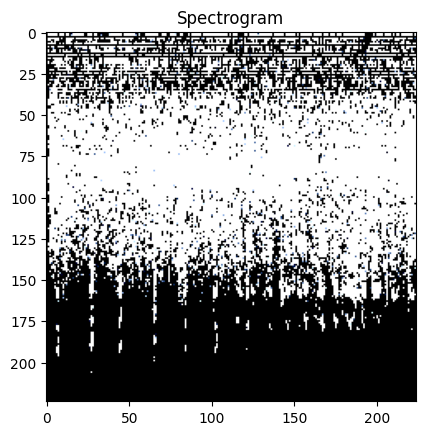

In [22]:
import matplotlib.pyplot as plt
plt.imshow(data[2112][0].permute(1,2,0).cpu())
plt.title("Spectrogram")

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, embedding_dim = 768  , patch_size = 16 , in_channels = 3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = in_channels , out_channels = embedding_dim , 
                             kernel_size = patch_size , stride = patch_size ,padding = 0)
        self.flatten = nn.Flatten(start_dim = 2 , end_dim = 3)
    
    def forward(self , x):
        return self.flatten(self.conv(x))
patcher = ConvBlock()
patched = patcher(torch.rand(32,3 , 128,313))
print(f"shape = {patched.shape}")

shape = torch.Size([32, 768, 152])


In [15]:
class AttnBlock(nn.Module):
    def __init__(self , embedding_dim = 768 , num_heads=12  , attn_dropout = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim 
                                                   ,num_heads = num_heads ,
                                      dropout = attn_dropout, batch_first = True)
    
    def forward(self , x):
        x = self.layer_norm(x)
        attn_output , _ = self.multihead_attn(query = x , key = x , value = x , need_weights =False)
        return attn_output
attner = AttnBlock()
attned = attner(patched.permute(0,2,1))
print(f"Shape = {attned.shape}")

Shape = torch.Size([32, 152, 768])


In [16]:
class LSTMBlock(nn.Module):
    def __init__(self , input_size = 768 , hidden_features = 1024):
        super().__init__()
        self.lstm = nn.RNN(input_size = input_size , hidden_size = hidden_features,batch_first = True)
    def forward(self , x):
        batch_size , num_pat , dim_size = x.size()
        inp = x.reshape(batch_size , -1)
        output , (h_n ,c_n) = self.lstm(x)
        last_output = output[:, -1, :]
        return last_output
lstmer = LSTMBlock()
print(f"shape Before = {attned.size()}")
lstmed = lstmer(attned)
print(f"Shape after = {lstmed.shape}")

shape Before = torch.Size([32, 152, 768])


ValueError: not enough values to unpack (expected 2, got 1)

In [18]:
class BirdClefMyModel(nn.Module):
    def __init__(self , out_features = 264):
        super().__init__()
        self.conv = ConvBlock()
        self.attn = AttnBlock()
        self.lstm = LSTMBlock()
        self.classifier = nn.Sequential(nn.Linear(in_features = 1024 , out_features = 512),
                                        nn.ReLU(),
                                        nn.Dropout(p =0.3),
                                       nn.Linear(in_features = 512 , out_features = 264))
    def forward(self , x):
        x = self.conv(x)
        x = self.attn(x.permute(0,2,1))
        x = self.lstm(x)
        x = self.classifier(x)
        return x
model = BirdClefMyModel().to(device)
model(torch.rand(32,3 , 128,313).to(device)).shape

NameError: name 'ConvBlock' is not defined

In [9]:
import timm
model = timm.create_model('efficientvit_l2.r224_in1k', pretrained=True , num_classes = 264)
model = model.to(device)
model = torch.load("/kaggle/working/model_path/model_custom_pooled_model.pth").to(device)

model.safetensors:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [43]:
torch.manual_seed(12)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data , test_data = torch.utils.data.random_split(dataset = data ,lengths = [ train_size , test_size])


train_dataloader = DataLoader(dataset = train_data , batch_size = 32 , shuffle = True , num_workers = 0)
test_dataloader = DataLoader(dataset = test_data , batch_size = 32 , shuffle = False , num_workers =0)
dataloader2 = DataLoader(dataset = test_data , batch_size = 32 , shuffle = False , num_workers =0)
dataloader4 = DataLoader(dataset = train_data , batch_size = 32 , shuffle = True , num_workers = 0)
from torchinfo import summary
summary(model=model, 
        input_size=(32,3,128,313), 
        
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
EfficientVitLarge (EfficientVitLarge)                             [32, 3, 128, 313]    [32, 264]            --                   True
├─Stem (stem)                                                     [32, 3, 128, 313]    [32, 32, 64, 157]    --                   True
│    └─ConvNormAct (in_conv)                                      [32, 3, 128, 313]    [32, 32, 64, 157]    --                   True
│    │    └─Dropout (dropout)                                     [32, 3, 128, 313]    [32, 3, 128, 313]    --                   --
│    │    └─Conv2d (conv)                                         [32, 3, 128, 313]    [32, 32, 64, 157]    864                  True
│    │    └─BatchNorm2d (norm)                                    [32, 32, 64, 157]    [32, 32, 64, 157]    64                   True
│    │    └─GELUTanh (act)                                 

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm

def train_step(model, dataloader, loss_fn, optimizer, scheduler):
    model.train()
    train_loss, train_acc = 0, 0
    
    with tqdm(enumerate(dataloader), desc="Training", total=len(dataloader) , leave = True) as progress:
        for batch, (X, y) in progress:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)
            train_loss += loss.item() 

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            progress.set_postfix(loss=loss.item(), lr=current_lr)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def test_step(model, dataloader, loss_fn):
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader), desc="Testing", leave=True, total=len(dataloader)):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn=nn.CrossEntropyLoss(), epochs=5, device='cuda', early_stopping_patience=3):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)
        
        tqdm.write(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Check for early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            model_path = Path("model_path")
            model_path.mkdir(exist_ok = True , parents = True)
            torch.save(obj = model.to("cpu") , f = model_path / "model_custom_pooled_model.pth")
            torch.save(obj = (model.to("cpu")).state_dict() , f = model_path / "model_custom_pooled_state_dict.pth")
            tqdm.write(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    return results


loss_fn = nn.CrossEntropyLoss()
num_epochs = 1 # Modify epochs here 
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5,weight_decay = 1e-6)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dataloader)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.001)

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      loss_fn=loss_fn, 
                      epochs=num_epochs,
                      device=device,
                      early_stopping_patience=1)


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/424 [00:00<?, ?it/s]

Testing:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 1: train_loss=1.5079, train_acc=0.6324, test_loss=1.1290, test_acc=0.7044


In [26]:
model_results

{'train_loss': [1.507896122364503],
 'train_acc': [0.6323702830188679],
 'test_loss': [1.1290034831694837],
 'test_acc': [0.7043855725439168]}

In [28]:
model_path = Path("model_path")
model_path.mkdir(exist_ok = True , parents = True)
torch.save(obj = model.to("cpu") , f = model_path / "model_custom_pooled_model.pth")
torch.save(obj = (model.to("cpu")).state_dict() , f = model_path / "model_custom_pooled_state_dict.pth")

In [11]:
import timm
class BirdClefModel(nn.Module):
    def __init__(self , output_size = 264):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True)
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.classifier = nn.Sequential(nn.Dropout(p = 0.2 , inplace = True)
            ,nn.Linear(in_features = 1280 , out_features = output_size , bias = True))
        
        
    def forward(self , x):
        return self.model(x)
request = requests.get("https://github.com/u-r-a-bot/Bird_clef_audio_proc/raw/main/prediction/model_effnet_b0_model.pth")
with open("model_effnet_b0_model.pth" , "wb") as f:
    f.write(request.content)
model1 = torch.load("model_effnet_b0_model.pth" , map_location=torch.device('cpu')).to(device)
model2 = torch.load("/kaggle/working/model_path/model_custom_pooled_model.pth").to(device)

In [16]:
sequential_block = nn.Sequential(
                    nn.ReLU(),
                    nn.Linear(in_features = 264+264, out_features = 512),
                    nn.Dropout(p= 0.1),
                    nn.Linear(in_features = 512 , out_features = 300),
                    nn.ReLU(),
                    nn.Dropout(p = 0.1),
                    nn.Linear(in_features = 300 , out_features = 264)
)

In [15]:
torch.concat((torch.rand(23)  ,torch.rand(23))).shape

torch.Size([46])

In [25]:
next(iter(zip(dataloader1 , dataloader2)))[1][0].shape

torch.Size([32, 3, 224, 224])

In [48]:
optimizer = torch.optim.SGD(sequential_block.parameters() , lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
def ensembled(model_1 , model_2 , data_loader1, data_loader2, sequential_block :torch.nn.Sequential):
    acc =0
    for batch, ((X1,y1),(X2,y2)) in tqdm(enumerate(zip(data_loader1 , data_loader2)) ,desc = "Dataloader1" , total = len(dataloader1)):
        model.eval()
        X1, y1 = X1.to(device),y1.to(device)
        X2, y2 = X2.to(device),y2.to(device)
        with torch.inference_mode():
            y_preds1 = model1(X1).squeeze()
            y_preds2 = model2(X2).squeeze()
        sequential_block.train()
        sequential_block.to(device)
        inp = torch.concat((y_preds1  ,y_preds2) , dim = 1).to(device)
        out = y1 
        logits = sequential_block(inp)
        pred = torch.argmax(torch.softmax(logits,dim =1),dim= 1)
        loss = loss_fn(logits , out)
        acc += (( pred== y1).sum().item()/len(pred))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return acc/len(data_loader1)
ensembled(model_1 = model1, model_2 = model2, data_loader1 = dataloader1, data_loader2 = dataloader2,
         sequential_block = sequential_block)

Dataloader1: 100%|██████████| 106/106 [04:32<00:00,  2.57s/it]


0.038355969420949904

In [ ]:
def ensembled_outputs(model_1 , model_2 , data_loader1, data_loader2, sequential_block :torch.nn.Sequential):
    acc =0
    loss = 0
    for batch, ((X1,y1),(X2,y2)) in tqdm(enumerate(zip(data_loader1 , data_loader2)) ,desc = "Dataloader1" , total = len(dataloader1)):
        model.eval()
        X1, y1 = X1.to(device),y1.to(device)
        X2, y2 = X2.to(device),y2.to(device)
        with torch.inference_mode():
            y_preds1 = model1(X1).squeeze()
            y_preds2 = model2(X2).squeeze()
            inp = torch.concat((y_preds1  ,y_preds2) , dim = 1).to(device)
            logits = sequential_block(inp)
            pred = torch.argmax(torch.softmax(logits,dim =1),dim= 1)
            acc += (( pred== y1).sum().item()/len(pred))
            loss+= loss.item

    return {"acc" : acc/len(data_loader1) , "loss" : loss/len(data_loader2)}
ensembled_outputs(model_1 = model1, model_2 = model2, data_loader1 = dataloader1, data_loader2 = dataloader2,
         sequential_block = sequential_block)

In [46]:
torch.save(sequential_block , "seq_block.pth")

In [15]:
def evaluator(model1 , model2 , dataloader1 , dataloader2 , device = device):
    evals = {"logits1": [] ,"logits2" : [] ,  "label": []}
    for batch, (X,y) in tqdm(enumerate(dataloader1) ,desc = "Dataloader1",total = len(dataloader1)):
        model.eval()
        X , y = X.to(device) , y.to(device)
        with torch.inference_mode():
            y_preds1 = torch.argmax(torch.softmax(model1(X) ,dim = 1) ,dim = 1)
            evals["logits1"].append(y_preds1.cpu().numpy())
            evals["label"].append(y.cpu().numpy())
    for batch, (X,y) in tqdm(enumerate(dataloader2) ,desc = "Dataloader2" , total = len(dataloader2)):
        model.eval()
        X , y = X.to(device) , y.to(device)
        with torch.inference_mode():
            y_preds2 = torch.argmax(torch.softmax(model2(X) ,dim = 1) ,dim = 1)
            evals["logits2"].append(y_preds2.cpu().numpy())
    return evals
ans = evaluator(model1 = model1, model2 = model2 , dataloader1 = dataloader1, dataloader2 = dataloader2)        


Dataloader2:   0%|          | 0/106 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(ant

In [24]:
some_logits_1 , some_logits_2, some_labels  =ans["logits1"][:10] , ans['logits2'][:10], ans["label"][:10]
some_logits_1[:10][1] ,some_logits_2[:10][1] ,some_labels[:10][1]

(array([ 74,  31, 169, 245, 221,  97,  61,  84, 115, 178,  97,  73, 106,
         73,  70,  71,  60,  95,   9,  71, 260, 247, 169,  86,  89,  20,
         80, 256, 263,   6,  73, 221]),
 array([ 74, 201, 219, 245,  70,  97, 103,  84,  26, 178,  97,  73, 106,
         73,  70,  13,  60,  95, 130,  71,  29, 247, 210, 106,  89,  20,
        134,  58, 263,  28,  73, 221]),
 array([ 74,  31, 169, 245,  31,  97, 103,  84,  26,  56,  97,  73, 106,
         84,  70,  13,  60,  95, 130,  71,  69, 247, 210,  60,  89,  20,
        134, 196, 263,  28,  73, 221]))

In [37]:
all_1_preds = np.concatenate([x for x in ans["logits1"]])
all_2_preds = np.concatenate([x for x in ans["logits2"]])
all_label = np.concatenate([x for x in ans["label"]])
all_1_preds.shape , all_2_preds.shape , all_label.shape

((3389,), (3389,), (3389,))

In [39]:
final_df = pd.DataFrame()
final_df["model_1"] = all_1_preds
final_df["model_2"] = all_2_preds
final_df["label"] = all_label
final_df.to_csv("ensemble_data.csv")

In [6]:
final_df = pd.read_csv("ensemble_data.csv", usecols = ["model_1", "model_2" , "label"])
X = final_df.drop("label" , axis = 1)
y = final_df.pop("label")

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.5, random_state=42)
# log_model = LogisticRegression() #Not so Good
# log_model.fit(X_train_set ,y_train_set)
rfclf = RandomForestClassifier(n_estimators = 1000 , )
rfclf.fit(X_train , y_train)


RandomForestClassifier(n_estimators=1000)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test , rfclf.predict(X_test))

0.5799410029498525

In [26]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.5, random_state=42)
xgbclf = XGBClassifier()
y_train = le.fit_transform(y_train)
xgbclf.fit(X_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
accuracy_score(y_test , le.inverse_transform(xgbclf.predict(X_test)))

0.6200589970501474

In [29]:
from sklearn import svm 
svc = svm.SVC()
svc.fit(X_train,y_train)
accuracy_score(y_test , le.inverse_transform(svc.predict(X_test)))

0.15870206489675517

In [40]:
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [38]:
import torch
import torchaudio
from torchvision import transforms

target_labels = [
        'abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1', 'afecuc1',
        'affeag1', 'afgfly1', 'afghor1', 'afmdov1', 'afpfly1', 'afpkin1',
        'afpwag1', 'afrgos1', 'afrgrp1', 'afrjac1', 'afrthr1', 'amesun2',
        'augbuz1', 'bagwea1', 'barswa', 'bawhor2', 'bawman1', 'bcbeat1',
        'beasun2', 'bkctch1', 'bkfruw1', 'blacra1', 'blacuc1', 'blakit1',
        'blaplo1', 'blbpuf2', 'blcapa2', 'blfbus1', 'blhgon1', 'blhher1',
        'blksaw1', 'blnmou1', 'blnwea1', 'bltapa1', 'bltbar1', 'bltori1',
        'blwlap1', 'brcale1', 'brcsta1', 'brctch1', 'brcwea1', 'brican1',
        'brobab1', 'broman1', 'brosun1', 'brrwhe3', 'brtcha1', 'brubru1',
        'brwwar1', 'bswdov1', 'btweye2', 'bubwar2', 'butapa1', 'cabgre1',
        'carcha1', 'carwoo1', 'categr', 'ccbeat1', 'chespa1', 'chewea1',
        'chibat1', 'chtapa3', 'chucis1', 'cibwar1', 'cohmar1', 'colsun2',
        'combul2', 'combuz1', 'comsan', 'crefra2', 'crheag1', 'crohor1',
        'darbar1', 'darter3', 'didcuc1', 'dotbar1', 'dutdov1', 'easmog1',
        'eaywag1', 'edcsun3', 'egygoo', 'equaka1', 'eswdov1', 'eubeat1',
        'fatrav1', 'fatwid1', 'fislov1', 'fotdro5', 'gabgos2', 'gargan',
        'gbesta1', 'gnbcam2', 'gnhsun1', 'gobbun1', 'gobsta5', 'gobwea1',
        'golher1', 'grbcam1', 'grccra1', 'grecor', 'greegr', 'grewoo2',
        'grwpyt1', 'gryapa1', 'grywrw1', 'gybfis1', 'gycwar3', 'gyhbus1',
        'gyhkin1', 'gyhneg1', 'gyhspa1', 'gytbar1', 'hadibi1', 'hamerk1',
        'hartur1', 'helgui', 'hipbab1', 'hoopoe', 'huncis1', 'hunsun2',
        'joygre1', 'kerspa2', 'klacuc1', 'kvbsun1', 'laudov1', 'lawgol',
        'lesmaw1', 'lessts1', 'libeat1', 'litegr', 'litswi1', 'litwea1',
        'loceag1', 'lotcor1', 'lotlap1', 'luebus1', 'mabeat1', 'macshr1',
        'malkin1', 'marsto1', 'marsun2', 'mcptit1', 'meypar1', 'moccha1',
        'mouwag1', 'ndcsun2', 'nobfly1', 'norbro1', 'norcro1', 'norfis1',
        'norpuf1', 'nubwoo1', 'pabspa1', 'palfly2', 'palpri1', 'piecro1',
        'piekin1', 'pitwhy', 'purgre2', 'pygbat1', 'quailf1', 'ratcis1',
        'raybar1', 'rbsrob1', 'rebfir2', 'rebhor1', 'reboxp1', 'reccor',
        'reccuc1', 'reedov1', 'refbar2', 'refcro1', 'reftin1', 'refwar2',
        'rehblu1', 'rehwea1', 'reisee2', 'rerswa1', 'rewsta1', 'rindov',
        'rocmar2', 'rostur1', 'ruegls1', 'rufcha2', 'sacibi2', 'sccsun2',
        'scrcha1', 'scthon1', 'shesta1', 'sichor1', 'sincis1', 'slbgre1',
        'slcbou1', 'sltnig1', 'sobfly1', 'somgre1', 'somtit4', 'soucit1',
        'soufis1', 'spemou2', 'spepig1', 'spewea1', 'spfbar1', 'spfwea1',
        'spmthr1', 'spwlap1', 'squher1', 'strher', 'strsee1', 'stusta1',
        'subbus1', 'supsta1', 'tacsun1', 'tafpri1', 'tamdov1', 'thrnig1',
        'trobou1', 'varsun2', 'vibsta2', 'vilwea1', 'vimwea1', 'walsta1',
        'wbgbir1', 'wbrcha2', 'wbswea1', 'wfbeat1', 'whbcan1', 'whbcou1',
        'whbcro2', 'whbtit5', 'whbwea1', 'whbwhe3', 'whcpri2', 'whctur2',
        'wheslf1', 'whhsaw1', 'whihel1', 'whrshr1', 'witswa1', 'wlwwar',
        'wookin1', 'woosan', 'wtbeat1', 'yebapa1', 'yebbar1', 'yebduc1',
        'yebere1', 'yebgre1', 'yebsto1', 'yeccan1', 'yefcan', 'yelbis1',
        'yenspu1', 'yertin1', 'yesbar1', 'yespet1', 'yetgre1', 'yewgre1'
        ]
import torch
import torchaudio
from torchvision import transforms
import torchvision.transforms.functional as TF

def preprocess(filepath, sampling_rate=32000, num_mels=224, min_freq=128, max_freq=16000,
               n_fft=1024, hop_length=512, num_samples=5*32_000, device='cpu'):

    audio_tensor, sr = torchaudio.load(filepath)
    

    if sr != sampling_rate:
        resampler = torchaudio.transforms.Resample(sr, sampling_rate).to(device)
        audio_tensor = resampler(audio_tensor)

    if num_samples is not None:
        if audio_tensor.shape[1] > num_samples:
            audio_tensor = audio_tensor[:, :num_samples]
        elif audio_tensor.shape[1] < num_samples:
            num_missing_samples = num_samples - audio_tensor.shape[1]
            last_dim_padding = (0, num_missing_samples)
            audio_tensor = torch.nn.functional.pad(audio_tensor, last_dim_padding)
    

    time_shift = torchaudio.transforms.TimeMasking(5)
    audio_tensor = time_shift(audio_tensor)

    transform = torchaudio.transforms.MelSpectrogram(sample_rate=sampling_rate,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=num_mels,
                                                     f_min=min_freq,
                                                     f_max=max_freq).to(device)
    audio_tensor_mel_spec = transform(audio_tensor.to(device))
    
    audio_tensor_mel_spec_db = torchaudio.transforms.AmplitudeToDB()(audio_tensor_mel_spec)
    
    mel_spec_img = torch.stack([audio_tensor_mel_spec_db.squeeze()] * 3)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        normalize
    ])
    preprocessed_img = transform(mel_spec_img)
    
    return preprocessed_img




def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive.

    Args:
        file_id (str): The file ID from Google Drive.
        destination (str): The destination path where the file will be saved.
    """
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, destination, quiet=False)


def get_predictions(inp_path ): 
    file_id = "1uuYaUhLnZGdzT5iLaFweACWrY7WNET-3"
    destination = "efficientvit.pth"
    model_path = Path("efficientvit.pth")
    if model_path.exists():
        print("Skipping download")
    else:    
        print("Model Downloading")
        download_file_from_google_drive(file_id, destination)
    
    audio = preprocess(filepath=inp_path).unsqueeze(dim = 0)
    print(f"shape of audio = {audio.shape}")
    loaded_model = torch.load(model_path)
    loaded_model.eval()
    with torch.inference_mode():
        y_logits = loaded_model(audio)
        y_preds = torch.softmax(y_logits, dim = 1)
        y_label = torch.argmax(y_preds , dim = 1)
    y_label = y_label.numpy()[0]
    return target_labels[y_label]

get_predictions("/kaggle/input/birdclef-2023/train_audio/brubru1/XC381539.ogg")



Skipping download
shape of audio = torch.Size([1, 3, 224, 224])


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


'brubru1'

In [39]:
audio_path_list =list( base_dir.glob("*/*.ogg"))

In [ ]:
def predictor(audio_path_list , num_samples):
    random_samples = random.sample(audio_path_list , k =num_samples)
    for path in random_samples:
        preds = get_predictions(path)
        original_val = str(path).split("/")[5]
        print(f"Predicted value = {preds} original Value = {original_val}       {preds==original_val}")
predictor(audio_path_list , 50)

Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = ratcis1 original Value = ratcis1       True
Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = rbsrob1 original Value = rbsrob1       True
Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = btweye2 original Value = btweye2       True
Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = hoopoe original Value = hoopoe       True
Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = combuz1 original Value = combuz1       True
Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = supsta1 original Value = supsta1       True
Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = strher original Value = strher       True
Skipping download
shape of audio = torch.Size([1, 3, 224, 224])
Predicted value = eubeat1 original Value = eubeat1       T

In [ ]:
    def preprocess(filepath):
        audio_tensor , sr = torchaudio.load(filepath)
        resampler = torchaudio.transforms.Resample(sr, self.sr).to(self.device)
        if sr != self.sr:
            audio_tensor = resampler(audio_tensor)
        if audio_tensor.shape[1] > self.num_samples:
            audio_tensor = audio_tensor[:,:self.num_samples]
        audio_length = audio_tensor.shape[1]
        if audio_tensor.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - audio_length
            last_dim_padding = (0, num_missing_samples)
            audio_tensor = torch.nn.functional.pad(audio_tensor , last_dim_padding)
        time_shift = torchaudio.transforms.TimeMasking(5)
        audio_tensor = time_shift(audio_tensor)
        transform = nn.Sequential(torchaudio.transforms.MelSpectrogram(sample_rate = 32_000,
                                                  n_fft = 1024 ,hop_length = 80
                                                  n_mels = 224 , f_min = 128,
                                                  f_max = 16_000) ,
                                  torchaudio.transforms.AmplitudeToDB()).to(device)
        audio_tensor_mel_spec = transform(audio_tensor.to(device))
        mel_spec_img = torch.stack([audio_tensor_mel_spec.squeeze() , audio_tensor_mel_spec.squeeze() , audio_tensor_mel_spec.squeeze()] )
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        transform = torchvision.transforms.Compose([
            transforms.Resize((224, 224) ),
            normalize
        ])
        return transform(mel_spec_img)

In [2]:
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [23]:
def test_step(model, dataloader, loss_fn):
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader), desc="Test Batch", leave=False, total=len(dataloader)):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc
test_step(model =model , dataloader = test_dataloader, loss_fn = nn.CrossEntropyLoss())

(1.127718172545703, 0.70435507482108)

In [1]:
import torchaudio
import torch 
from torch import nn
from tqdm import tqdm
from pathlib import Path
import numpy as np
import librosa
import timm 
import torchvision
from torchvision import transforms
import requests
import gdown

specie_to_name = {'abethr1': 'African Bare-eyed Thrush',
 'abhori1': 'African Black-headed Oriole',
 'abythr1': 'Abyssinian Thrush',
 'afbfly1': 'African Blue Flycatcher',
 'afdfly1': 'African Dusky Flycatcher',
 'afecuc1': 'African Emerald Cuckoo',
 'affeag1': 'African Fish-Eagle',
 'afgfly1': 'African Gray Flycatcher',
 'afghor1': 'African Gray Hornbill',
 'afmdov1': 'Mourning Collared-Dove',
 'afpfly1': 'African Paradise-Flycatcher',
 'afpkin1': 'African Pygmy Kingfisher',
 'afpwag1': 'African Pied Wagtail',
 'afrgos1': 'African Goshawk',
 'afrgrp1': 'African Green-Pigeon',
 'afrjac1': 'African Jacana',
 'afrthr1': 'African Thrush',
 'amesun2': 'Amethyst Sunbird',
 'augbuz1': 'Augur Buzzard',
 'bagwea1': 'Baglafecht Weaver',
 'barswa': 'Barn Swallow',
 'bawhor2': 'Black-and-white-casqued Hornbill',
 'bawman1': 'Black-and-white Mannikin',
 'bcbeat1': 'Blue-cheeked Bee-eater',
 'beasun2': 'Beautiful Sunbird',
 'bkctch1': 'Black-crowned Tchagra',
 'bkfruw1': 'Black-faced Rufous-Warbler',
 'blacra1': 'Black Crake',
 'blacuc1': 'Black Cuckoo',
 'blakit1': 'Black Kite',
 'blaplo1': 'Blacksmith Lapwing',
 'blbpuf2': 'Black-backed Puffback',
 'blcapa2': 'Black-collared Apalis',
 'blfbus1': 'Black-fronted Bushshrike',
 'blhgon1': 'Black-headed Gonolek',
 'blhher1': 'Black-headed Heron',
 'blksaw1': 'Black Sawwing',
 'blnmou1': 'Blue-naped Mousebird',
 'blnwea1': 'Black-necked Weaver',
 'bltapa1': 'Black-throated Apalis',
 'bltbar1': 'Black-throated Barbet',
 'bltori1': 'Black-tailed Oriole',
 'blwlap1': 'Black-winged Lapwing',
 'brcale1': 'Brown-chested Alethe',
 'brcsta1': 'Bristle-crowned Starling',
 'brctch1': 'Brown-crowned Tchagra',
 'brcwea1': 'Brown-capped Weaver',
 'brican1': 'Brimstone Canary',
 'brobab1': 'Brown Babbler',
 'broman1': 'Bronze Mannikin',
 'brosun1': 'Bronze Sunbird',
 'brrwhe3': 'Kikuyu White-eye',
 'brtcha1': 'Brown-tailed Chat',
 'brubru1': 'Brubru',
 'brwwar1': 'Brown Woodland-Warbler',
 'bswdov1': 'Blue-spotted Wood-Dove',
 'btweye2': 'Brown-throated Wattle-eye',
 'bubwar2': 'Buff-bellied Warbler',
 'butapa1': 'Buff-throated Apalis',
 'cabgre1': "Cabanis's Greenbul",
 'carcha1': 'Cape Robin-Chat',
 'carwoo1': 'Cardinal Woodpecker',
 'categr': 'Cattle Egret',
 'ccbeat1': 'Cinnamon-chested Bee-eater',
 'chespa1': 'Chestnut Sparrow',
 'chewea1': 'Chestnut Weaver',
 'chibat1': 'Chinspot Batis',
 'chtapa3': 'Chestnut-throated Apalis',
 'chucis1': "Chubb's Cisticola",
 'cibwar1': 'Cinnamon Bracken-Warbler',
 'cohmar1': 'Common House-Martin',
 'colsun2': 'Collared Sunbird',
 'combul2': 'Common Bulbul',
 'combuz1': 'Common Buzzard',
 'comsan': 'Common Sandpiper',
 'crefra2': 'Crested Francolin',
 'crheag1': 'Crowned Eagle',
 'crohor1': 'Crowned Hornbill',
 'darbar1': "D'Arnaud's Barbet",
 'darter3': 'African Darter',
 'didcuc1': 'Dideric Cuckoo',
 'dotbar1': 'Double-toothed Barbet',
 'dutdov1': 'Dusky Turtle-Dove',
 'easmog1': 'Eastern Mountain Greenbul',
 'eaywag1': 'Western Yellow Wagtail',
 'edcsun3': 'Eastern Double-collared Sunbird',
 'egygoo': 'Egyptian Goose',
 'equaka1': 'Equatorial Akalat',
 'eswdov1': 'Emerald-spotted Wood-Dove',
 'eubeat1': 'European Bee-eater',
 'fatrav1': 'Fan-tailed Raven',
 'fatwid1': 'Fan-tailed Widowbird',
 'fislov1': "Fischer's Lovebird",
 'fotdro5': 'Fork-tailed Drongo',
 'gabgos2': 'Gabar Goshawk',
 'gargan': 'Garganey',
 'gbesta1': 'Greater Blue-eared Starling',
 'gnbcam2': 'Gray-backed Camaroptera',
 'gnhsun1': 'Green-headed Sunbird',
 'gobbun1': 'Golden-breasted Bunting',
 'gobsta5': 'Golden-breasted Starling',
 'gobwea1': 'Golden-backed Weaver',
 'golher1': 'Goliath Heron',
 'grbcam1': 'Green-backed Camaroptera',
 'grccra1': 'Gray Crowned-Crane',
 'grecor': 'Great Cormorant',
 'greegr': 'Great Egret',
 'grewoo2': 'Green Woodhoopoe',
 'grwpyt1': 'Green-winged Pytilia',
 'gryapa1': 'Gray Apalis',
 'grywrw1': 'Gray Wren-Warbler',
 'gybfis1': 'Gray-backed Fiscal',
 'gycwar3': 'Gray-capped Warbler',
 'gyhbus1': 'Gray-headed Bushshrike',
 'gyhkin1': 'Gray-headed Kingfisher',
 'gyhneg1': 'Gray-headed Nigrita',
 'gyhspa1': 'Northern Gray-headed Sparrow',
 'gytbar1': 'Gray-throated Barbet',
 'hadibi1': 'Hadada Ibis',
 'hamerk1': 'Hamerkop',
 'hartur1': "Hartlaub's Turaco",
 'helgui': 'Helmeted Guineafowl',
 'hipbab1': "Hinde's Pied-Babbler",
 'hoopoe': 'Eurasian Hoopoe',
 'huncis1': "Hunter's Cisticola",
 'hunsun2': "Hunter's Sunbird",
 'joygre1': 'Joyful Greenbul',
 'kerspa2': 'Kenya Rufous Sparrow',
 'klacuc1': "Klaas's Cuckoo",
 'kvbsun1': 'Eastern Violet-backed Sunbird',
 'laudov1': 'Laughing Dove',
 'lawgol': "Lawrence's Goldfinch",
 'lesmaw1': 'Lesser Masked-Weaver',
 'lessts1': 'Lesser Striped Swallow',
 'libeat1': 'Little Bee-eater',
 'litegr': 'Little Egret',
 'litswi1': 'Little Swift',
 'litwea1': 'Little Weaver',
 'loceag1': 'Long-crested Eagle',
 'lotcor1': 'Long-tailed Cormorant',
 'lotlap1': 'Long-toed Lapwing',
 'luebus1': "Lühder's Bushshrike",
 'mabeat1': 'Madagascar Bee-eater',
 'macshr1': "Mackinnon's Shrike",
 'malkin1': 'Malachite Kingfisher',
 'marsto1': 'Marabou Stork',
 'marsun2': 'Mariqua Sunbird',
 'mcptit1': 'Mouse-colored Penduline-Tit',
 'meypar1': "Meyer's Parrot",
 'moccha1': 'Mocking Cliff-Chat',
 'mouwag1': 'Mountain Wagtail',
 'ndcsun2': 'Northern Double-collared Sunbird',
 'nobfly1': 'Northern Black-Flycatcher',
 'norbro1': 'Northern Brownbul',
 'norcro1': 'Northern Crombec',
 'norfis1': 'Northern Fiscal',
 'norpuf1': 'Northern Puffback',
 'nubwoo1': 'Nubian Woodpecker',
 'pabspa1': 'Parrot-billed Sparrow',
 'palfly2': 'Pale Flycatcher',
 'palpri1': 'Pale Prinia',
 'piecro1': 'Pied Crow',
 'piekin1': 'Pied Kingfisher',
 'pitwhy': 'Pin-tailed Whydah',
 'purgre2': 'Purple Grenadier',
 'pygbat1': 'Pygmy Batis',
 'quailf1': 'Quailfinch',
 'ratcis1': 'Rattling Cisticola',
 'raybar1': 'Red-and-yellow Barbet',
 'rbsrob1': 'Red-backed Scrub-Robin',
 'rebfir2': 'Red-billed Firefinch',
 'rebhor1': 'Northern Red-billed Hornbill',
 'reboxp1': 'Red-billed Oxpecker',
 'reccor': 'Red-cheeked Cordonbleu',
 'reccuc1': 'Red-chested Cuckoo',
 'reedov1': 'Red-eyed Dove',
 'refbar2': 'Red-fronted Barbet',
 'refcro1': 'Red-faced Crombec',
 'reftin1': 'Red-fronted Tinkerbird',
 'refwar2': 'Red-fronted Prinia',
 'rehblu1': 'Red-headed Bluebill',
 'rehwea1': 'Red-headed Weaver',
 'reisee2': "Reichenow's Seedeater",
 'rerswa1': 'Red-rumped Swallow',
 'rewsta1': 'Red-winged Starling',
 'rindov': 'Ring-necked Dove',
 'rocmar2': 'Rock Martin',
 'rostur1': "Ross's Turaco",
 'ruegls1': "Rüppell's Starling",
 'rufcha2': 'Rufous Chatterer',
 'sacibi2': 'African Sacred Ibis',
 'sccsun2': 'Scarlet-chested Sunbird',
 'scrcha1': 'Snowy-crowned Robin-Chat',
 'scthon1': 'Scaly-throated Honeyguide',
 'shesta1': "Shelley's Starling",
 'sichor1': 'Silvery-cheeked Hornbill',
 'sincis1': 'Singing Cisticola',
 'slbgre1': 'Slender-billed Greenbul',
 'slcbou1': 'Slate-colored Boubou',
 'sltnig1': 'Slender-tailed Nightjar',
 'sobfly1': 'Southern Black-Flycatcher',
 'somgre1': 'Sombre Greenbul',
 'somtit4': 'Somali Tit',
 'soucit1': 'Southern Citril',
 'soufis1': 'Southern Fiscal',
 'spemou2': 'Speckled Mousebird',
 'spepig1': 'Speckled Pigeon',
 'spewea1': 'Spectacled Weaver',
 'spfbar1': 'Spot-flanked Barbet',
 'spfwea1': 'Speckle-fronted Weaver',
 'spmthr1': 'Spotted Morning-Thrush',
 'spwlap1': 'Spur-winged Lapwing',
 'squher1': 'Squacco Heron',
 'strher': 'Striated Heron',
 'strsee1': 'Streaky Seedeater',
 'stusta1': "Stuhlmann's Starling",
 'subbus1': 'Sulphur-breasted Bushshrike',
 'supsta1': 'Superb Starling',
 'tacsun1': 'Tacazze Sunbird',
 'tafpri1': 'Tawny-flanked Prinia',
 'tamdov1': 'Tambourine Dove',
 'thrnig1': 'Thrush Nightingale',
 'trobou1': 'Tropical Boubou',
 'varsun2': 'Variable Sunbird',
 'vibsta2': 'Violet-backed Starling',
 'vilwea1': 'Village Weaver',
 'vimwea1': 'Vitelline Masked-Weaver',
 'walsta1': "Waller's Starling",
 'wbgbir1': 'White-bellied Go-away-bird',
 'wbrcha2': 'White-browed Robin-Chat',
 'wbswea1': 'White-browed Sparrow-Weaver',
 'wfbeat1': 'White-fronted Bee-eater',
 'whbcan1': 'White-bellied Canary',
 'whbcou1': 'White-browed Coucal',
 'whbcro2': 'White-browed Crombec',
 'whbtit5': 'White-bellied Tit',
 'whbwea1': 'White-headed Buffalo-Weaver',
 'whbwhe3': 'Pale White-eye',
 'whcpri2': 'White-chinned Prinia',
 'whctur2': 'White-crested Turaco',
 'wheslf1': 'White-eyed Slaty-Flycatcher',
 'whhsaw1': 'White-headed Sawwing',
 'whihel1': 'White Helmetshrike',
 'whrshr1': 'White-rumped Shrike',
 'witswa1': 'Wire-tailed Swallow',
 'wlwwar': 'Willow Warbler',
 'wookin1': 'Woodland Kingfisher',
 'woosan': 'Wood Sandpiper',
 'wtbeat1': 'White-throated Bee-eater',
 'yebapa1': 'Yellow-breasted Apalis',
 'yebbar1': 'Yellow-billed Barbet',
 'yebduc1': 'Yellow-billed Duck',
 'yebere1': 'Yellow-bellied Eremomela',
 'yebgre1': 'Yellow-bellied Greenbul',
 'yebsto1': 'Yellow-billed Stork',
 'yeccan1': 'Yellow-crowned Canary',
 'yefcan': 'Yellow-fronted Canary',
 'yelbis1': 'Yellow Bishop',
 'yenspu1': 'Yellow-necked Francolin',
 'yertin1': 'Yellow-rumped Tinkerbird',
 'yesbar1': 'Yellow-spotted Barbet',
 'yespet1': 'Yellow-spotted Bush Sparrow',
 'yetgre1': 'Yellow-throated Greenbul',
 'yewgre1': 'Yellow-whiskered Greenbul'}

target_labels = [
        'abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1', 'afecuc1',
        'affeag1', 'afgfly1', 'afghor1', 'afmdov1', 'afpfly1', 'afpkin1',
        'afpwag1', 'afrgos1', 'afrgrp1', 'afrjac1', 'afrthr1', 'amesun2',
        'augbuz1', 'bagwea1', 'barswa', 'bawhor2', 'bawman1', 'bcbeat1',
        'beasun2', 'bkctch1', 'bkfruw1', 'blacra1', 'blacuc1', 'blakit1',
        'blaplo1', 'blbpuf2', 'blcapa2', 'blfbus1', 'blhgon1', 'blhher1',
        'blksaw1', 'blnmou1', 'blnwea1', 'bltapa1', 'bltbar1', 'bltori1',
        'blwlap1', 'brcale1', 'brcsta1', 'brctch1', 'brcwea1', 'brican1',
        'brobab1', 'broman1', 'brosun1', 'brrwhe3', 'brtcha1', 'brubru1',
        'brwwar1', 'bswdov1', 'btweye2', 'bubwar2', 'butapa1', 'cabgre1',
        'carcha1', 'carwoo1', 'categr', 'ccbeat1', 'chespa1', 'chewea1',
        'chibat1', 'chtapa3', 'chucis1', 'cibwar1', 'cohmar1', 'colsun2',
        'combul2', 'combuz1', 'comsan', 'crefra2', 'crheag1', 'crohor1',
        'darbar1', 'darter3', 'didcuc1', 'dotbar1', 'dutdov1', 'easmog1',
        'eaywag1', 'edcsun3', 'egygoo', 'equaka1', 'eswdov1', 'eubeat1',
        'fatrav1', 'fatwid1', 'fislov1', 'fotdro5', 'gabgos2', 'gargan',
        'gbesta1', 'gnbcam2', 'gnhsun1', 'gobbun1', 'gobsta5', 'gobwea1',
        'golher1', 'grbcam1', 'grccra1', 'grecor', 'greegr', 'grewoo2',
        'grwpyt1', 'gryapa1', 'grywrw1', 'gybfis1', 'gycwar3', 'gyhbus1',
        'gyhkin1', 'gyhneg1', 'gyhspa1', 'gytbar1', 'hadibi1', 'hamerk1',
        'hartur1', 'helgui', 'hipbab1', 'hoopoe', 'huncis1', 'hunsun2',
        'joygre1', 'kerspa2', 'klacuc1', 'kvbsun1', 'laudov1', 'lawgol',
        'lesmaw1', 'lessts1', 'libeat1', 'litegr', 'litswi1', 'litwea1',
        'loceag1', 'lotcor1', 'lotlap1', 'luebus1', 'mabeat1', 'macshr1',
        'malkin1', 'marsto1', 'marsun2', 'mcptit1', 'meypar1', 'moccha1',
        'mouwag1', 'ndcsun2', 'nobfly1', 'norbro1', 'norcro1', 'norfis1',
        'norpuf1', 'nubwoo1', 'pabspa1', 'palfly2', 'palpri1', 'piecro1',
        'piekin1', 'pitwhy', 'purgre2', 'pygbat1', 'quailf1', 'ratcis1',
        'raybar1', 'rbsrob1', 'rebfir2', 'rebhor1', 'reboxp1', 'reccor',
        'reccuc1', 'reedov1', 'refbar2', 'refcro1', 'reftin1', 'refwar2',
        'rehblu1', 'rehwea1', 'reisee2', 'rerswa1', 'rewsta1', 'rindov',
        'rocmar2', 'rostur1', 'ruegls1', 'rufcha2', 'sacibi2', 'sccsun2',
        'scrcha1', 'scthon1', 'shesta1', 'sichor1', 'sincis1', 'slbgre1',
        'slcbou1', 'sltnig1', 'sobfly1', 'somgre1', 'somtit4', 'soucit1',
        'soufis1', 'spemou2', 'spepig1', 'spewea1', 'spfbar1', 'spfwea1',
        'spmthr1', 'spwlap1', 'squher1', 'strher', 'strsee1', 'stusta1',
        'subbus1', 'supsta1', 'tacsun1', 'tafpri1', 'tamdov1', 'thrnig1',
        'trobou1', 'varsun2', 'vibsta2', 'vilwea1', 'vimwea1', 'walsta1',
        'wbgbir1', 'wbrcha2', 'wbswea1', 'wfbeat1', 'whbcan1', 'whbcou1',
        'whbcro2', 'whbtit5', 'whbwea1', 'whbwhe3', 'whcpri2', 'whctur2',
        'wheslf1', 'whhsaw1', 'whihel1', 'whrshr1', 'witswa1', 'wlwwar',
        'wookin1', 'woosan', 'wtbeat1', 'yebapa1', 'yebbar1', 'yebduc1',
        'yebere1', 'yebgre1', 'yebsto1', 'yeccan1', 'yefcan', 'yelbis1',
        'yenspu1', 'yertin1', 'yesbar1', 'yespet1', 'yetgre1', 'yewgre1'
        ]


def preprocess(filepath, sampling_rate=32000, num_mels=224, min_freq=128, max_freq=16000,
               n_fft=1024, hop_length=512, num_samples=5*32_000, device='cpu'):

    audio_tensor, sr = torchaudio.load(filepath)
    

    if sr != sampling_rate:
        resampler = torchaudio.transforms.Resample(sr, sampling_rate).to(device)
        audio_tensor = resampler(audio_tensor)

    if num_samples is not None:
        if audio_tensor.shape[1] > num_samples:
            audio_tensor = audio_tensor[:, :num_samples]
        elif audio_tensor.shape[1] < num_samples:
            num_missing_samples = num_samples - audio_tensor.shape[1]
            last_dim_padding = (0, num_missing_samples)
            audio_tensor = torch.nn.functional.pad(audio_tensor, last_dim_padding)
    

    time_shift = torchaudio.transforms.TimeMasking(5)
    audio_tensor = time_shift(audio_tensor)

    transform = torchaudio.transforms.MelSpectrogram(sample_rate=sampling_rate,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=num_mels,
                                                     f_min=min_freq,
                                                     f_max=max_freq).to(device)
    audio_tensor_mel_spec = transform(audio_tensor.to(device))
    
    audio_tensor_mel_spec_db = torchaudio.transforms.AmplitudeToDB()(audio_tensor_mel_spec)
    
    mel_spec_img = torch.stack([audio_tensor_mel_spec_db.squeeze()] * 3)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        normalize
    ])
    preprocessed_img = transform(mel_spec_img)
    
    return preprocessed_img




def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive.

    Args:
        file_id (str): The file ID from Google Drive.
        destination (str): The destination path where the file will be saved.
    """
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, destination, quiet=False)


def get_predictions(inp_path ): 
    file_id = "1uuYaUhLnZGdzT5iLaFweACWrY7WNET-3"
    destination = "efficientvit.pth"
    model_path = Path("efficientvit.pth")
    if model_path.exists():
        print("Skipping download")
    else:    
        print("Model Downloading")
        download_file_from_google_drive(file_id, destination)
    
    audio = preprocess(filepath=inp_path).unsqueeze(dim = 0)
    loaded_model =None
    try:
        loaded_model = torch.load(model_path)
        print("Load Successful")
    except Exception:
        print("failed Loading")
    loaded_model.eval()
    with torch.inference_mode():
        y_logits = loaded_model(audio)
        y_preds = torch.softmax(y_logits, dim = 1)
        y_label = torch.argmax(y_preds , dim = 1)
    y_label = y_label.numpy()[0]
    return specie_to_name[target_labels[y_label]]






ModuleNotFoundError: No module named 'gdown'

In [ ]:
get_predictions("/kaggle/input/birdclef-2023/train_audio/abethr1/XC756300.ogg")

TypeError: Cannot handle this data type: (1, 1, 3, 4), |u1

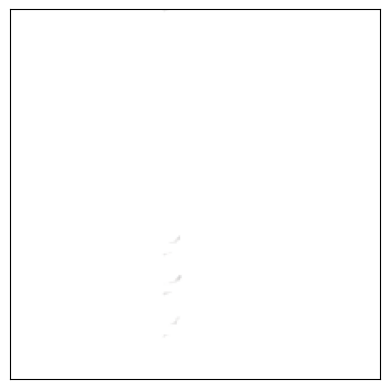

In [54]:
import PIL
import matplotlib
def specshow(file_path , sampling_rate = 32000 , num_mels = 128 , 
                 min_freq = 128 , max_freq = 16000 , n_fft = 3200 
                 , hop_length = 80 , num_samples  = None , device = device ):
    
        audio_path = file_path
        audio_tensor , sr = torchaudio.load(audio_path)
        resampler = torchaudio.transforms.Resample(sr, sampling_rate).to(device)
        if num_samples is None:
            num_samples = sampling_rate * 5
        if sr!= sampling_rate:
            audio_tensor = resampler(audio_tensor)
        if audio_tensor.shape[1] > num_samples:
            audio_tensor = audio_tensor[:,:num_samples]
        audio_length = audio_tensor.shape[1]
        if audio_tensor.shape[1] < num_samples:
            num_missing_samples = num_samples - audio_length
            last_dim_padding = (0, num_missing_samples)
            audio_tensor = torch.nn.functional.pad(audio_tensor , last_dim_padding)
        
        transform = nn.Sequential(torchaudio.transforms.MelSpectrogram(sample_rate = sampling_rate,
                                                  n_fft = n_fft , hop_length = hop_length,
                                                  n_mels = num_mels , f_min = min_freq,
                                                  f_max = max_freq) ,
                                  torchaudio.transforms.AmplitudeToDB()).to(device)
        mel_spec = transform(audio_tensor.to(device))
        mel_spec_img = torch.stack([mel_spec.squeeze() , mel_spec.squeeze() , mel_spec.squeeze()] )
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224) , antialias = True ),
            normalize,
        ])
        img = (1 - (transforms(mel_spec_img).permute(2,1,0) /255)).numpy()
        return img


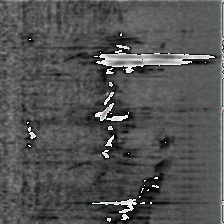

In [74]:
from PIL import Image
img = Image.open("output_image.jpg")
img

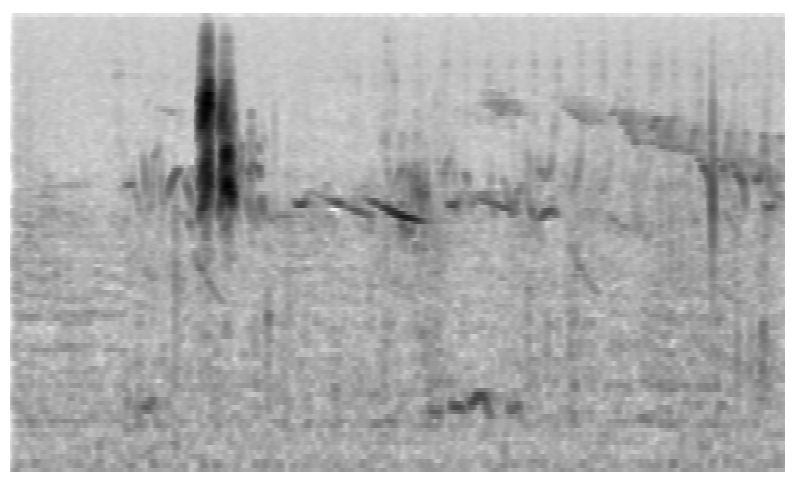

In [81]:
import librosa
import librosa.display

def specshow(file_path, save_path, sampling_rate=32000, n_fft=3200, hop_length=80, num_mels=128,
             min_freq=128, max_freq=16000, num_samples=None, t=5,device=device):
    
    audio_path = file_path
    audio, sr = librosa.load(audio_path, sr=sampling_rate)
    
    if num_samples is None:
        num_samples = sampling_rate * t
    
    if len(audio) > num_samples:
        audio = audio[:num_samples]
    elif len(audio) < num_samples:
        audio = librosa.util.pad_center(audio, num_samples)
    
    # Compute the Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                              n_mels=num_mels, fmin=min_freq, fmax=max_freq)
    
    # Convert to decibel scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='gray_r')
    plt.axis('off')  # Turn off axis
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)  # Save without padding
#     plt.close()

# Example usage
specshow("/kaggle/input/birdclef-2023/train_audio/afgfly1/XC267773.ogg", "output_image.jpg")


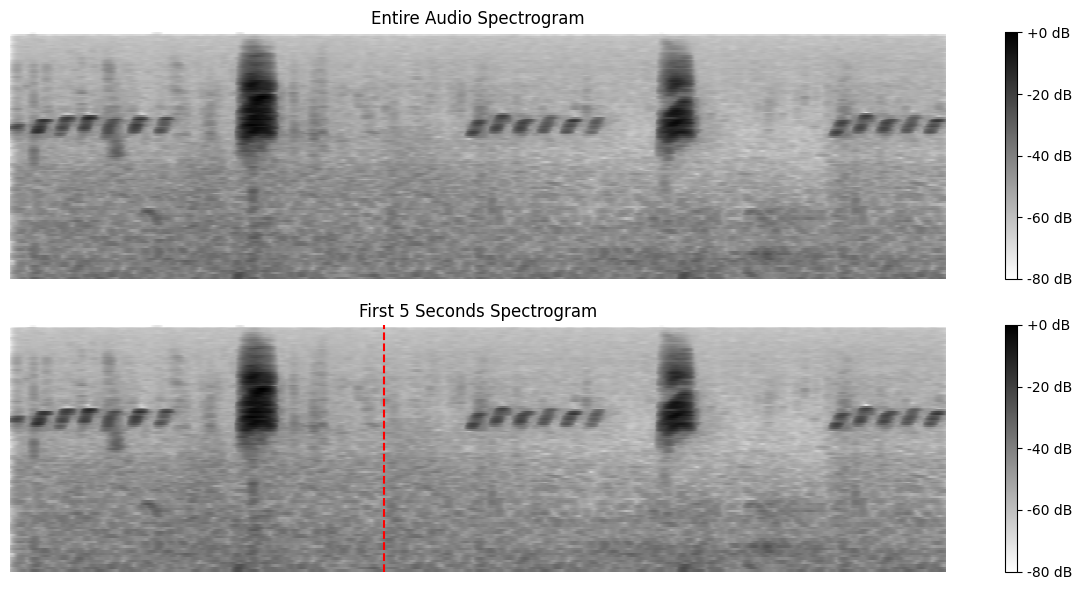

In [89]:
import librosa
import librosa.display

def specshow_with_separator(file_path, save_path, sampling_rate=32000, n_fft=3200, hop_length=80, num_mels=128,
                            min_freq=128, max_freq=16000, num_samples=None, device=device, separator_time=5,
                            vertical_line_time=2):
    
    audio_path = file_path
    audio, sr = librosa.load(audio_path, sr=sampling_rate)
    
    if num_samples is None:
        num_samples = sampling_rate * 5
    
    if len(audio) > num_samples:
        audio = audio[:num_samples]
    elif len(audio) < num_samples:
        audio = librosa.util.pad_center(audio, num_samples)
    
    # Compute the Mel spectrogram for the entire audio
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                              n_mels=num_mels, fmin=min_freq, fmax=max_freq)
    
    # Convert to decibel scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Compute the Mel spectrogram for the first 5 seconds
    audio_first_5_seconds = audio[:separator_time * sampling_rate]
    mel_spec_first_5_seconds = librosa.feature.melspectrogram(y=audio_first_5_seconds, sr=sr,
                                                              n_fft=n_fft, hop_length=hop_length,
                                                              n_mels=num_mels, fmin=min_freq, fmax=max_freq)
    mel_spec_db_first_5_seconds = librosa.power_to_db(mel_spec_first_5_seconds, ref=np.max)
    
    # Plot the entire audio spectrogram
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='gray_r')
    plt.title('Entire Audio Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.axis('off')
    
    # Plot the first 5 seconds spectrogram with separator line
    plt.subplot(2, 1, 2)
    librosa.display.specshow(mel_spec_db_first_5_seconds, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='mel', cmap='gray_r')
    
    # Add vertical line
    plt.axvline(x=vertical_line_time, color='r', linestyle='--')
    
    plt.title('First 5 Seconds Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
#     plt.close()

# Example usage
specshow_with_separator("/kaggle/input/birdclef-2023/train_audio/afgfly1/XC267774.ogg", "output_image_with_separator.jpg")


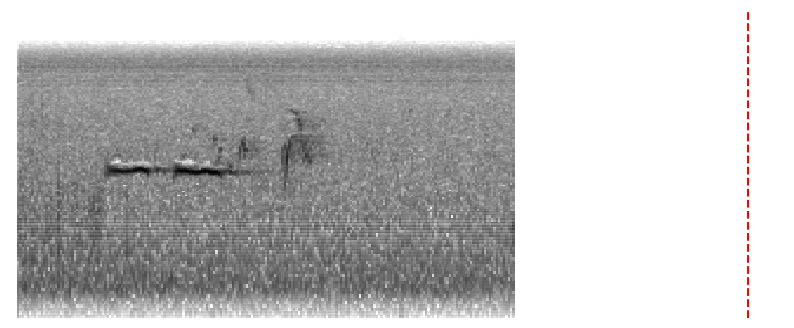

In [9]:
import librosa
import librosa.display
import numpy as np
device = "cpu"
import matplotlib.pyplot as plt
def specshow_with_separator(file_path, save_path, sampling_rate=32000, n_fft=1024, hop_length=512, num_mels=224,
                            min_freq=128, max_freq=16000, num_samples=None, device=device, separator_time=5,
                           displ_image = False):
    
    audio_path = file_path
    audio, sr = librosa.load(audio_path, sr=sampling_rate)
    
    if num_samples is None:
        num_samples = sampling_rate * 5
    
#     if len(audio) > num_samples:
#         audio = audio[:num_samples]
    elif len(audio) < num_samples:
        audio = librosa.util.pad_center(audio, num_samples)

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                              n_mels=num_mels, fmin=min_freq, fmax=max_freq)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='gray_r')
    plt.axvline(x=separator_time, color='r', linestyle='--')
    plt.axis('off') 
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)  
path = "/kaggle/input/birdclef-2023/train_audio/abethr1/XC756300.ogg"

specshow_with_separator(path, "output_image_with_separator.jpg" )


0.15870206489675517

# Trying Wav2Vec2 Model!!!

In [36]:
import torch
import torchaudio
# from torch.utils.data import Dataset
from datasets import Dataset
from pathlib import Path
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("Saads/bird_classification_model" , )
max_length = 1

class BirdClefAudio(Dataset):
    def __init__(self, base_dir, df, num_samples=None, device='cuda'):
        self.base_dir = Path(base_dir)
        self.df = df
        self.sampling_rate = 32000
        self.num_samples = num_samples
        self.device = device
        self.class_to_index = self.create_class_to_index_mapping()
    
    def create_class_to_index_mapping(self):
        unique_labels = sorted(set(self.df.primary_label))
        return {label: idx for idx, label in enumerate(unique_labels)}
    
    def __len__(self):
        return len(self.df)
    
    def preprocessor(self ,waveform):
        inputs = feature_extractor(waveform , sampling_rate = 16_000, padding = "max_length",max_length = max_length)
        return {'input_values': inputs['input_values']}
    
    def __getitem__(self, index):
        audio_path = self.base_dir / self.df.filename[index]
        waveform, sr = torchaudio.load(audio_path, normalize=True)
        
        # If specified, truncate or pad the audio to a fixed length
        if self.num_samples is not None:
            if waveform.size(1) > self.num_samples:
                waveform = waveform[:, :self.num_samples]
            elif waveform.size(1) < self.num_samples:
                padding = torch.zeros(1, self.num_samples - waveform.size(1))
                waveform = torch.cat([waveform, padding], dim=1)
        
        # Convert to mono if needed
        if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        label = self.class_to_index[self.df.primary_label[index]]
        inputs = self.preprocessor(waveform)
        inputs["input_values"] = inputs["input_values"][0]
        return inputs["input_values"],torch.tensor(label)
data = BirdClefAudio(base_dir ,train_df , num_samples = 80_000)
# data[10]["input_values"][0].shape
torch.manual_seed(12)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data , test_data = torch.utils.data.random_split(dataset = data ,lengths = [ train_size , test_size])


train_dataloader = DataLoader(dataset = train_data , batch_size = 1 , shuffle = True , num_workers = 0)
test_dataloader = DataLoader(dataset = test_data , batch_size = 1 , shuffle = False , num_workers =0)

In [46]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base",
)
model.classifier = nn.Linear(in_features= 256 , out_features = 264)
model.to(device)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [30]:
data[0][0].shape

(1, 80000)

In [7]:
# from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer


# model = AutoModelForAudioClassification.from_pretrained(
#     "Saads/bird_classification_model",
# )
# torch.manual_seed(12)
# data = BirdClefAudio(base_dir , train_df,num_samples = 80_000)
# train_size = int(0.8 * len(data))
# test_size = len(data) - train_size
# train_data , test_data = torch.utils.data.random_split(dataset = data ,lengths = [ train_size , test_size])


# train_dataloader = DataLoader(dataset = train_data , batch_size = 32 , shuffle = True , num_workers = 0)
# test_dataloader = DataLoader(dataset = test_data , batch_size = 32 , shuffle = False , num_workers =0)
# def compute_metrics(eval_pred):
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)
# import os
# os.environ["WANDB_DISABLED"] = "true"
# training_args = TrainingArguments(
#     output_dir="my_awesome_mind_model",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=3e-5,
#     per_device_train_batch_size=32,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=32,
#     num_train_epochs=3,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     push_to_hub=False,
#     report_to = None
    
    
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_data,
#     eval_dataset=test_data,
#     tokenizer=feature_extractor,
#     compute_metrics=compute_metrics,
# )

# trainer.train()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

def train_step(model, dataloader, loss_fn, optimizer, scheduler, max_grad_norm=None):
    model.train()
    train_loss, train_acc = 0, 0
    
    with tqdm(enumerate(dataloader), desc="Training", total=len(dataloader)) as progress:
        for batch, (X, y) in progress:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X.squeeze(dim=0)).logits
            loss = loss_fn(y_pred, y)
            loss.backward()
            
            # Gradient clipping
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                
            optimizer.step()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)
            train_loss += loss.item()

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            progress.set_postfix(loss=loss.item(), lr=current_lr)

            # Update learning rate if scheduler is provided
            if scheduler is not None:
                scheduler.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader), desc="Test Batch", leave=False, total=len(dataloader)):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X.squeeze(dim=0)).logits
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn=nn.CrossEntropyLoss(), epochs=5, device='cuda', early_stopping_patience=3, max_grad_norm=None):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, max_grad_norm=max_grad_norm)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Check for early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    return results


loss_fn = nn.CrossEntropyLoss()
num_epochs = 5
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=3e-05,
    betas=(0.9, 0.999),  
    eps=1e-08  ,
    weight_decay = 0.001
)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.01)

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      scheduler=None,
                      loss_fn=loss_fn, 
                      epochs=num_epochs,
                      device=device,
                      early_stopping_patience=1,
                      max_grad_norm=1.0)  # Set your desired max_grad_norm value


In [12]:
next(iter(train_dataloader))["label"]

tensor([167])